In [1]:
import os
import xarray as xr
from tqdm import tqdm 
import numpy as np
import ultraplot as uplt
# Interpolating u over time
from scipy.interpolate import interp1d, RegularGridInterpolator
from joblib import Parallel, delayed
# from functools import lru_cache

import sys
sys.path.append('src/lagranto_tracking')
from lagranto_track import *

In [2]:
# settings
seconds_one_sol = 24 * 60 * 60 + 39 * 60 + 35.244 # seconds per sol
steps_per_delta_time = 2 ### steps per delta time, should be an even number
radius = 3396200 # unit from km to m
p0 = 710
g = 3.71
H = 10 # scale height in km

In [3]:
### read LMD DATA, it defines the time range we are care about
data_dir = '/home/sunco/Projects/LAGRANTO/data/LMDZ_data' ### can be slow, so we should use the local data, you can copy to you local directory
file_name = 'concat_P_month_5.nc'
ds = xr.open_dataset(os.path.join(data_dir,file_name),decode_times=False)
ds

<xarray.Dataset> Size: 15GB
Dimensions:    (index: 100, GCM_layers: 73, latitude: 49, longitude: 65,
                Time: 1440, altitude: 91)
Coordinates:
  * latitude   (latitude) float32 196B 90.0 86.25 82.5 ... -82.5 -86.25 -90.0
  * longitude  (longitude) float32 260B -180.0 -174.4 -168.8 ... 174.4 180.0
  * Time       (Time) float32 6kB 258.0 258.1 258.1 258.2 ... 317.9 318.0 318.0
  * altitude   (altitude) float32 364B 1.006e+03 887.5 783.3 ... 0.01482 0.01308
Dimensions without coordinates: index, GCM_layers
Data variables: (12/16)
    controle   (index) float32 400B ...
    aps        (GCM_layers) float32 292B ...
    bps        (GCM_layers) float32 292B ...
    phisinit   (latitude, longitude) float32 13kB ...
    ps         (Time, latitude, longitude) float32 18MB ...
    zareoid    (Time, altitude, latitude, longitude) float32 2GB ...
    ...         ...
    w          (Time, altitude, latitude, longitude) float32 2GB ...
    rho        (Time, altitude, latitude, longitude) float32 2GB ...
    h2o_ice    (Time, altitude, latitude, longitude) float32 2GB ...
    h2o_vap    (Time, altitude, latitude, longitude) float32 2GB ...
    dustq      (Time, altitude, latitude, longitude) float32 2GB ...
    Ls         (Time) float32 6kB ...
Attributes:
    history:                    Mon Dec  2 19:47:19 2024: ncks -A -v Ls conca...
    history_of_appended_files:  Mon Dec  2 19:47:19 2024: Appended file conca...
    NCO:                        netCDF Operators version 5.0.6 (Homepage = ht...

In [4]:
lon = ds['longitude'].values
lat = ds['latitude'].values
pres = ds['altitude'].values ### unit in Pa in this case
time = ds['Time'].values
u = ds['u'].values
v = ds['v'].values
w = ds['w'].values
# rho = ds['rho'].values
# h2o_vap = ds['h2o_vap'].values
# ps = ds['ps'].values # we can just use the interped u,v,w to judge the lower boundary
time_array = time * seconds_one_sol # unit from days to seconds

alt = pres2alt(pres,p0,H)*1000 # unit from Pa to m
w = -w # positive w is downward in original data

In [5]:
u_copy = u.copy()
v_copy = v.copy()
w_copy = w.copy()
alt_copy = alt.copy()
time_array_copy = time_array.copy()


In [15]:
time_num = 72 * 4
u =u_copy[:time_num,:40,:,:]	
v = v_copy[:time_num,:40,:,:]
w = w_copy[:time_num,:40,:,:]
alt = alt_copy[:40]
time_array = time_array_copy[:time_num]

lat = np.flip(lat)
u = np.flip(u, axis=2)
v = np.flip(v, axis=2)
w = np.flip(w, axis=2)


In [16]:
new_time_points = np.linspace(time_array[0], time_array[-1], (len(time_array) - 1) * steps_per_delta_time + 1)
time_delta_in_seconds = new_time_points[1] - new_time_points[0]
print(time_delta_in_seconds, new_time_points.shape)

1850.0 (575,)


In [17]:
### interp the time series to the new time points with time step of steps_per_delta_time,

### interpolate the data to the new time points

### track the particles from these data, so the data also defines the time range we are care about

### fast linear interpolation here
u_time_interp = interpolate_4d_time(u, time_array, new_time_points)
v_time_interp = interpolate_4d_time(v, time_array, new_time_points)
w_time_interp = interpolate_4d_time(w, time_array, new_time_points)
# h2o_vap_time_interp = interpolate_4d_time(h2o_vap, time_array, new_time_points)

In [18]:
lower_boundary = 0
upper_boundary = alt.max()

print(f"lower_boundary: {lower_boundary/1000:.2f} km, upper_boundary: {upper_boundary/1000:.2f} km")

lower_boundary: 0.00 km, upper_boundary: 45.27 km


In [19]:
#### give some point to track
clon = 0
clat = 60
calt = 10*1e3 # unit in m

cilon = np.argmin(np.abs(lon - clon))
cilat = np.argmin(np.abs(lat - clat))
cialt = np.argmin(np.abs(alt - calt))

print(cilon, cilat, cialt)

need_track_initial_points = [(clon, clat, cialt)] # points we need to track
# need_track_initial_points.append((clon, clat, alt2pres(1,p0,H)))
# need_track_initial_points.append((0, 0, alt2pres(30,p0,H)))
# need_track_initial_points.append((0, 30, alt2pres(50,p0,H)))
need_track_initial_points.append((clon, clat, calt))
trajectory_dict = {} # dict of initial points in trajectory, 
for point_lon, point_lat, point_pres in need_track_initial_points:
	trajectory_dict[point_lon, point_lat, point_pres] = (point_lon, point_lat, point_pres)
	print('add ', point_lon, point_lat, point_pres)

32 40 11
add  0 60 11
add  0 60 10000.0


In [20]:
u_time_interp.shape,v_time_interp.shape,w_time_interp.shape,time_array.shape

((575, 40, 49, 65), (575, 40, 49, 65), (575, 40, 49, 65), (288,))

In [21]:
new_position_dict_list = track_particles_heun(new_time_points, u_time_interp, v_time_interp, w_time_interp, need_track_initial_points,
				alt, lat, lon, lower_boundary, upper_boundary,
				radius=3396200, verbose=False, w_positive_up=True, lon_mode=None)
trace_time = get_trace_time_heun(new_time_points)

In [22]:
def plot_trajectory(new_position_dict_list, start_points=None,time=None):
	# u_wind = []
	# v_wind = []
	# w_wind = []
	# for new_position_dict in new_position_dict_list:
	# 	for point_lon, point_lat, point_pres in new_position_dict.keys():
	# 		u_value, v_value, w_value = wind_dict[point_lon, point_lat, point_pres]
	# 		u_wind.append(u_value)
	# 		v_wind.append(v_value)
	# 		w_wind.append(w_value)
	
	lon_array = np.array([])
	lat_array = np.array([])
	alt_array = np.array([])

	plot_points = list(new_position_dict_list[0].keys())[-1]
	if start_points is None:
		start_points = list(new_position_dict_list[0].keys())[-1]
	for new_position_dict in tqdm(new_position_dict_list):
		lons, lats, alts = new_position_dict[plot_points]
		lon_array = np.append(lon_array, lons)
		lat_array = np.append(lat_array, lats)
		alt_array = np.append(alt_array, alts)

	fig, axs = uplt.subplots(ncols=2,nrows=2, figsize=(10, 6),share=False, hratios=(1,0.5))
	ax = axs[0]
	sc = ax.scatter(lon_array, lat_array, c=alt_array/1000, cmap='rainbow', s=15)
	ax.colorbar(sc, ax=ax, label='Altitude (km)')
	ax.scatter(start_points[0], start_points[1],  color='red6',marker='+', label='Start Point', s=125)
	ax.scatter(lon_array[~np.isinf(lon_array)][-1], lat_array[~np.isinf(lat_array)][-1], marker='x', color='red', label='End Point', s=125)
	ax.set_xlim(-180,180)
	ax.set_ylim(-90,90)
	ax.legend(loc='t')
	ax.format(xlabel='longitude',ylabel='latitude',xformatter='deglon',yformatter='deglat',\
		  fontsize=20,title='Lagrangian trajectory in lon x lat plane',ylocator=30)

	# ax = axs[1]
	# ax.plot(u_wind,c='r')
	# ax.legend(loc='t')
	# ax.format(xlabel='time (sol)',ylabel='zonal wind speed (m/s)')

	# ax = axs[2]
	# ax.plot(v_wind,c='b')
	# ax.legend(loc='t')
	# ax.format(xlabel='time (sol)',ylabel='meridional wind speed (m/s)')

	ax = axs[1]
	ax.plot(time, alt_array/1000,c='g',label='Altitude')
	ax.legend(loc='t')
	ax.format(xlabel='time (sol)',ylabel='altitude (km)',title='Altitude vs time')


	ax = axs[2]
	ax.scatter(time, lon_array, c='b',label='lon',s=1)
	# ax.legend(loc='t')
	ax.format(xlabel='time (sol)',ylabel='longitude',title='longitude vs time')


	ax = axs[3]
	ax.scatter(time, lat_array, c='m',label='lat',s=1)
	# ax.legend(loc='t')
	ax.format(xlabel='time (sol)',ylabel='latitude',title='latitude vs time')
	fig.format(abc=True,fontsize=12)

100%|██████████| 574/574 [00:00<00:00, 186601.34it/s]


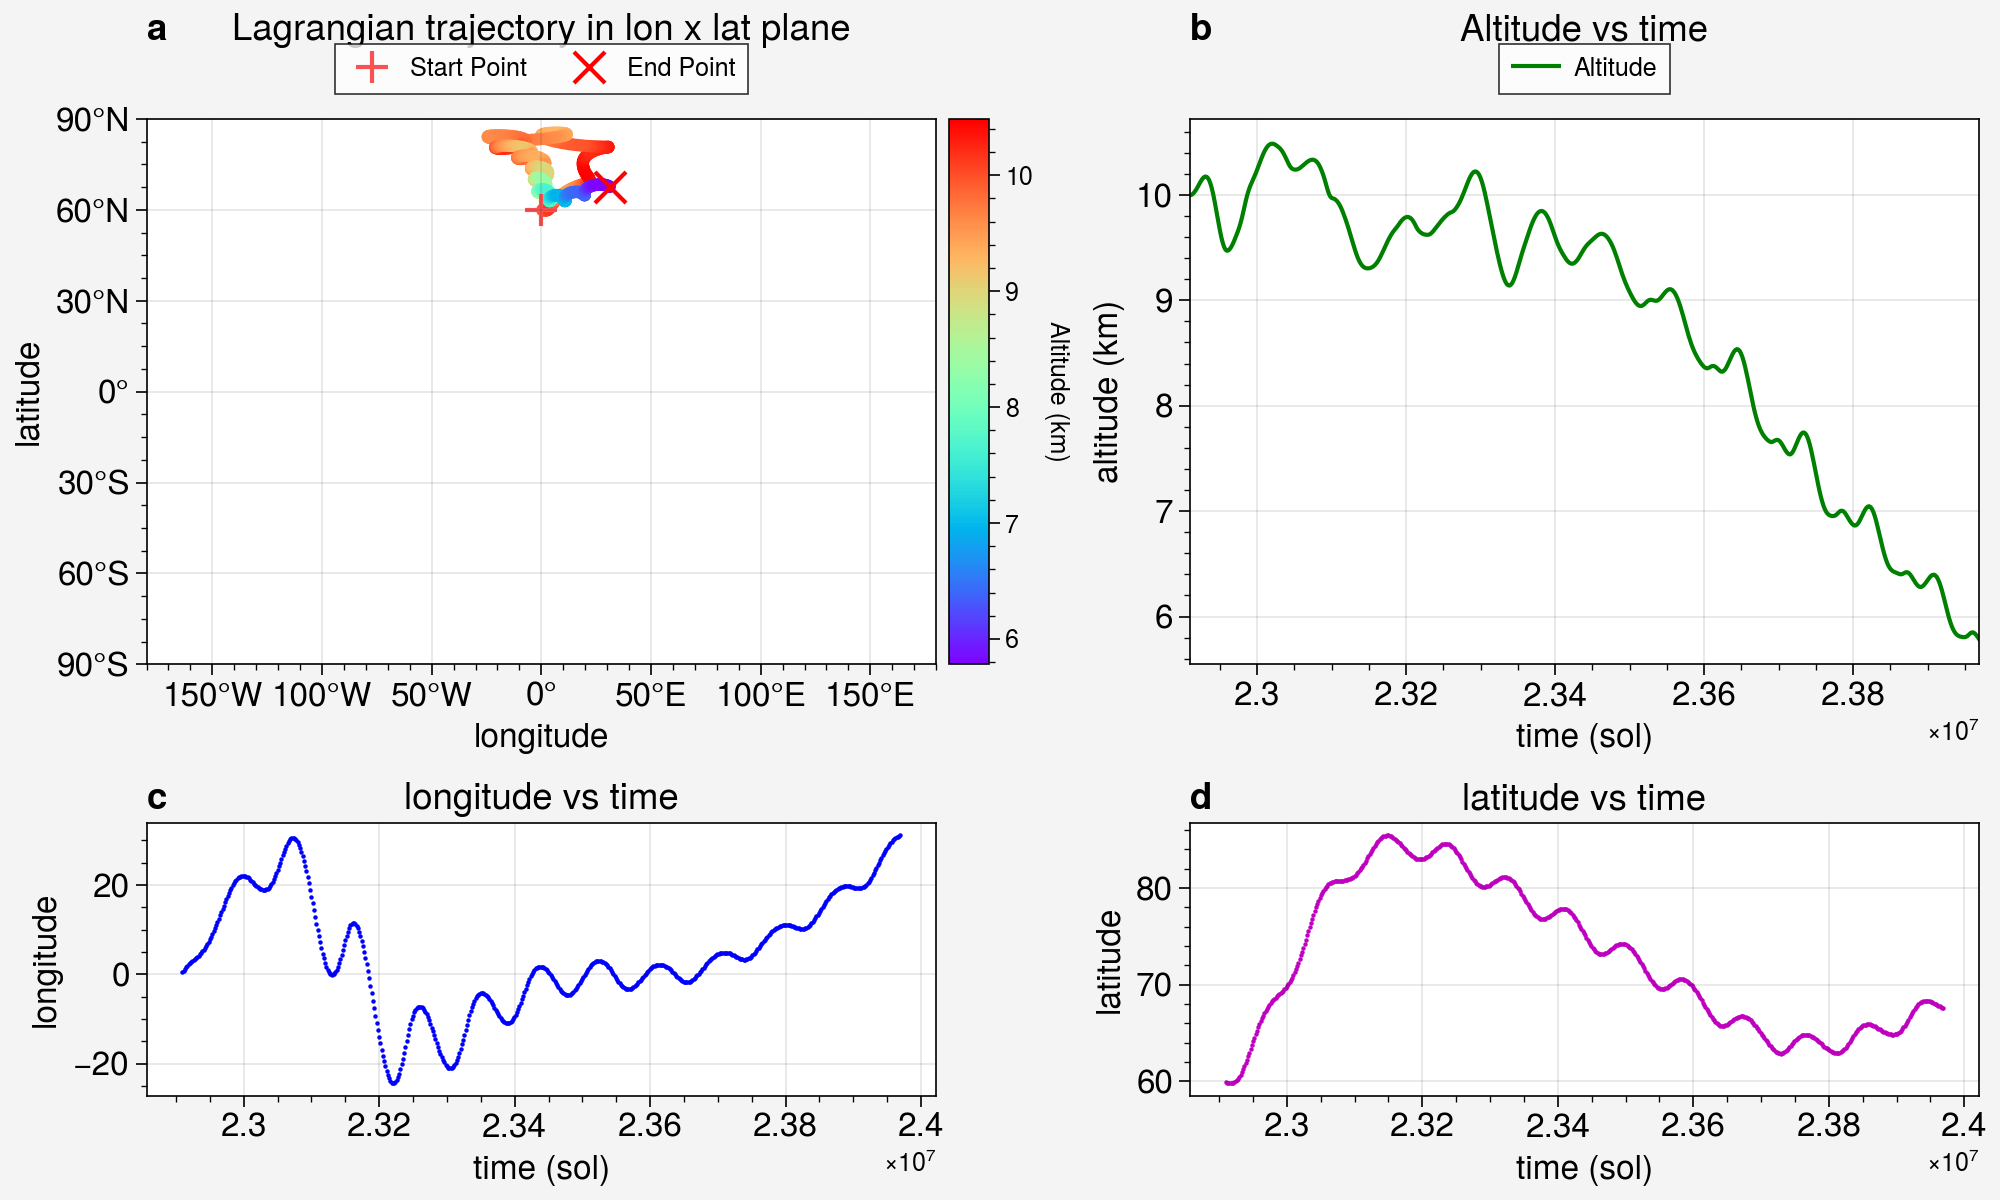

In [23]:
plot_trajectory(new_position_dict_list, start_points=None,time = trace_time)

In [24]:
final_dict = new_position_dict_list[-1]  # 最后一个时间步的结果：dict[(lon,lat,alt0)] -> (lonT,latT,altT)
seeds_back = [final_dict[pt] for pt in need_track_initial_points]  # [(lonT,latT,altT), ...]

new_position_dict_list_back = track_particles_heun_backward(
    new_time_points, u_time_interp, v_time_interp, w_time_interp,
    seeds_back,                      # 用前向末尾位置作为后向初始点
    alt, lat, lon,                  # 与前向一致的网格
    lower_boundary, upper_boundary, # m
    radius=3396200, verbose=False,
    w_positive_up=True,             # 与前向一致
    lon_mode=None,                  # 留空以自动推断（或按需显式设 '0_360'）
    start_time=new_time_points[-1]  # 从最后一个时间戳开始回放
)
trace_time_back = get_trace_time_heun_backward(
    new_time_points,
    start_time=new_time_points[-1]
)

100%|██████████| 574/574 [00:00<00:00, 220975.72it/s]


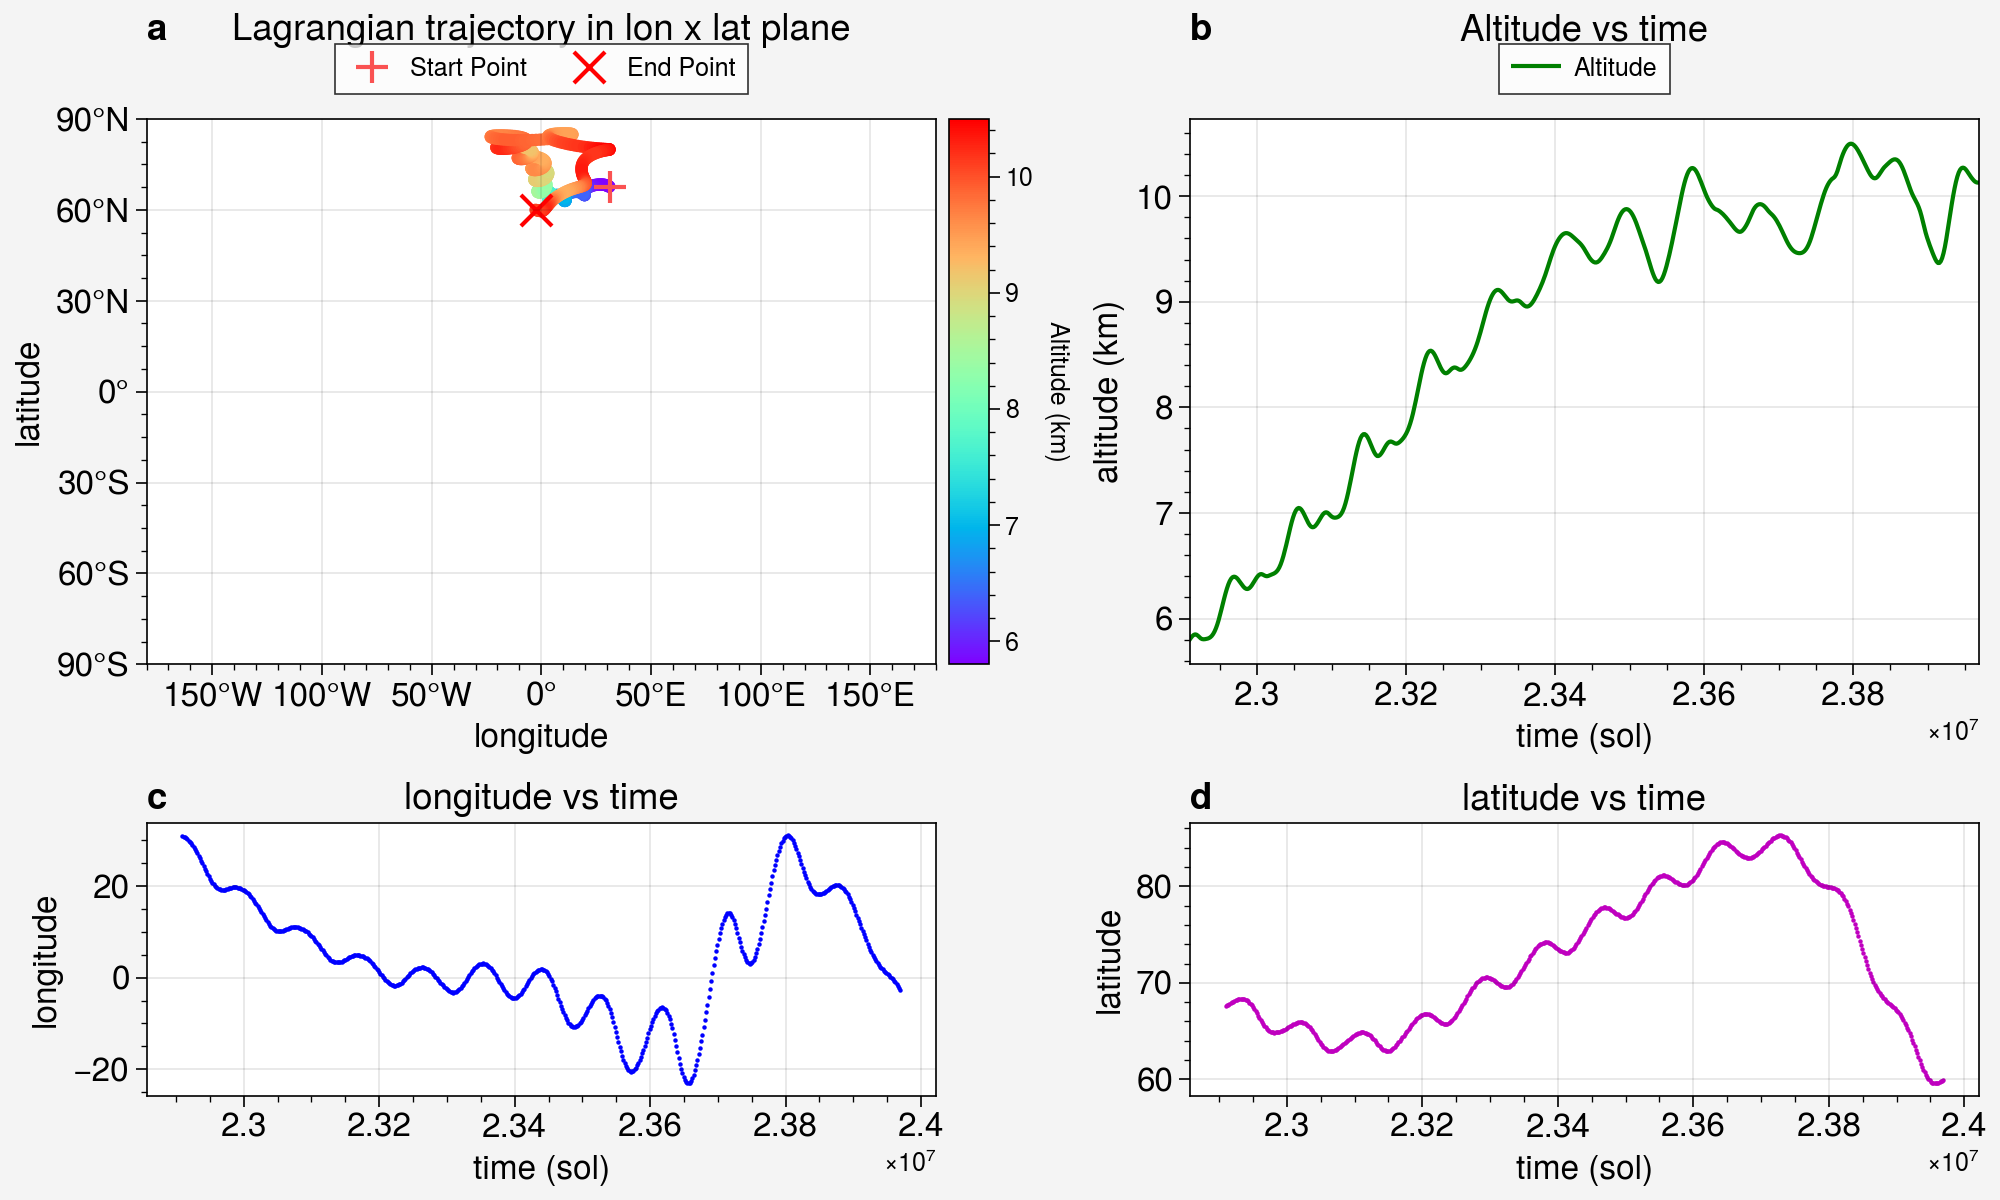

In [25]:
plot_trajectory(new_position_dict_list_back, start_points=None,time = trace_time)

In [26]:
def scatter_points_on_lat_alt_grid(center_lat, center_height, radius, num_points, \
						   upper_half_only=False, planet_radius=3396200):
	"""
	Scatter points on a given latitude and height grid, centered at a given point, within a circular range.
	:param center_lat: Latitude of the center point (in degrees)
	:param center_height: Height of the center point (in meters)
	:param radius: Radius of the circle (in meters)
	:param num_points: Number of points to scatter
	:param upper_half_only: Whether to consider only the upper half of the circle (boolean, default False)
	:param planet_radius: Radius of the planet (in meters), default is Earth's radius 6371000 meters
	:return: List of generated points, each represented by (latitude, height)
	"""
	
	
	points = []
	
	radius_lat = radius / (2*np.pi*planet_radius) * 360

	for _ in range(num_points):
		# Use random angle and random radius to determine the position of the point
		if upper_half_only:
			angle = np.random.uniform(0, np.pi)  # Consider only the upper half of the circle
		else:
			angle = np.random.uniform(0, 2 * np.pi)
		
		r = radius_lat * np.sqrt(np.random.uniform(0, 1))  # Ensure uniform distribution within the circle
		
		# Calculate the latitude change for the new point
		delta_lat = r * np.cos(angle)
		delta_height = radius * np.sin(angle)  # Assume height change uses the original radius unit
		
		# Determine the new point's coordinates
		new_lat = center_lat + delta_lat
		new_height = center_height + delta_height
		points.append((new_lat, new_height))
	
	return points

def random_longitude_points(num, min_longitude=-180.0, max_longitude=180.0):
	"""
	Generate random longitude points within a specified range.

	Parameters:
	num (int): The number of random longitude points to generate.
	min_longitude (float): Minimum longitude value, default is -180.0.
	max_longitude (float): Maximum longitude value, default is 180.0.

	Returns:
	list: A list of randomly generated longitude values, with length num, within the range [min_longitude, max_longitude].
	"""
	if not (-180.0 <= min_longitude <= 180.0) or not (-180.0 <= max_longitude <= 180.0):
		raise ValueError("Longitude range must be between -180.0 and 180.0")
	if min_longitude > max_longitude:
		raise ValueError("Minimum longitude cannot be greater than maximum longitude")

	return np.random.uniform(min_longitude, max_longitude, num)

In [29]:
center_lat = 30.0
center_height = 10000
cycle_radius = 30000
num_points = 500

scattered_points = scatter_points_on_lat_alt_grid(center_lat, center_height, cycle_radius, num_points, upper_half_only=True)
# scattered_points
random_longitudes = random_longitude_points(num_points)
trajectory_dict = {}
need_track_initial_points = []
for i, (point_lat, point_alt) in enumerate(scattered_points):
	need_track_initial_points.append((random_longitudes[i], point_lat, point_alt))
	trajectory_dict[random_longitudes[i], point_lat,point_alt] = (random_longitudes[i], point_lat, point_alt)


In [30]:
len(need_track_initial_points)

500

In [31]:
n_jobs = 8
initial_points_list = need_track_initial_points
n_jobs = int(np.min([n_jobs, len(initial_points_list)]))

print('using', n_jobs, 'jobs for parallel tracking')


segment_size = max(1, len(initial_points_list) // n_jobs)
segments = [initial_points_list[i:i + segment_size]
            for i in range(0, len(initial_points_list), segment_size)]


results = Parallel(n_jobs=n_jobs)(
    delayed(track_particles_heun)(
        time=new_time_points,
        u_time_interp=u_time_interp,
        v_time_interp=v_time_interp,
        w_time_interp=w_time_interp,
        need_track_initial_points=segment,
        alt_grid_m=alt,
        lat_grid=lat,
        lon_grid=lon,
        lower_boundary=lower_boundary,
        upper_boundary=upper_boundary,
        # 可选参数
        # radius=3396200,  # 如需覆盖默认行星半径再解开
        verbose=False,
        w_positive_up=True,    # 若数据里 w 向上为正则 True；相反则设为 False
        # lon_mode=None        # 让函数自动推断经度模式
    )
    for segment in tqdm(segments)
)


using 8 jobs for parallel tracking


100%|██████████| 9/9 [00:00<00:00, 51.56it/s]


In [32]:
# Combine results from all segments
new_position_dict_list = []
for timestep in tqdm(range(len(results[0])), desc='Combining results from all segments'):  # For each timestep
    combined_dict = {}
    for result in results:  # For each segment result
        combined_dict.update(result[timestep])
    new_position_dict_list.append(combined_dict)

Combining results from all segments: 100%|██████████| 574/574 [00:00<00:00, 34818.07it/s]


In [33]:
passing_by_points_count = np.zeros((len(trace_time)-1, u.shape[1],u.shape[2],u.shape[3]))
for itime in range(len(trace_time)-1):
	for one_time_dict_key in new_position_dict_list[itime].keys(): ### check the passing by points in the space grid in each time step
		point_lon, point_lat, point_alt = list(new_position_dict_list[itime][one_time_dict_key])
		if point_alt > lower_boundary and point_alt < upper_boundary:
			# Get indices for lat/lon grid cells using digitize
			lat_idx = np.digitize(point_lat, lat) 
			lon_idx = np.digitize(point_lon, lon) 
			alt_idx = np.digitize(point_alt, alt)
			print(itime, alt_idx, lat_idx, lon_idx)
			passing_by_points_count[itime, alt_idx, lat_idx, lon_idx] += 1

0 31 32 40
0 17 32 28
0 20 33 41
0 35 33 13
0 14 32 44
0 32 32 31
0 21 33 62
0 32 33 5
0 26 32 45
0 32 32 20
0 16 33 22
0 34 33 61
0 24 32 37
0 19 33 64
0 20 32 2
0 35 33 54
0 15 32 45
0 18 32 56
0 13 32 4
0 35 32 18
0 32 32 47
0 29 32 49
0 17 33 62
0 29 33 15
0 28 33 54
0 30 33 7
0 33 33 55
0 32 32 42
0 31 33 47
0 28 33 55
0 33 33 12
0 12 32 40
0 21 32 18
0 16 33 43
0 16 32 44
0 35 32 40
0 26 33 51
0 23 33 45
0 26 33 21
0 23 33 57
0 14 33 2
0 32 33 63
0 35 33 13
0 17 33 64
0 20 33 48
0 22 32 30
0 30 33 15
0 25 33 51
0 19 33 13
0 29 33 5
0 12 32 59
0 35 33 2
0 15 32 21
0 35 33 5
0 23 33 47
0 29 32 33
0 30 33 43
0 19 32 43
0 34 33 8
0 12 33 34
0 12 33 62
0 34 32 31
0 35 33 12
0 21 32 37
0 14 32 42
0 26 33 17
0 35 33 55
0 35 32 44
0 35 33 54
0 34 33 16
0 33 32 19
0 13 33 31
0 15 33 47
0 29 33 56
0 13 33 1
0 19 32 36
0 24 33 59
0 24 32 46
0 20 32 26
0 17 33 8
0 34 32 20
0 28 33 57
0 17 32 57
0 30 33 52
0 29 33 59
0 19 33 61
0 26 32 34
0 30 33 51
0 12 32 41
0 21 33 2
0 31 33 45
0 26 32 40


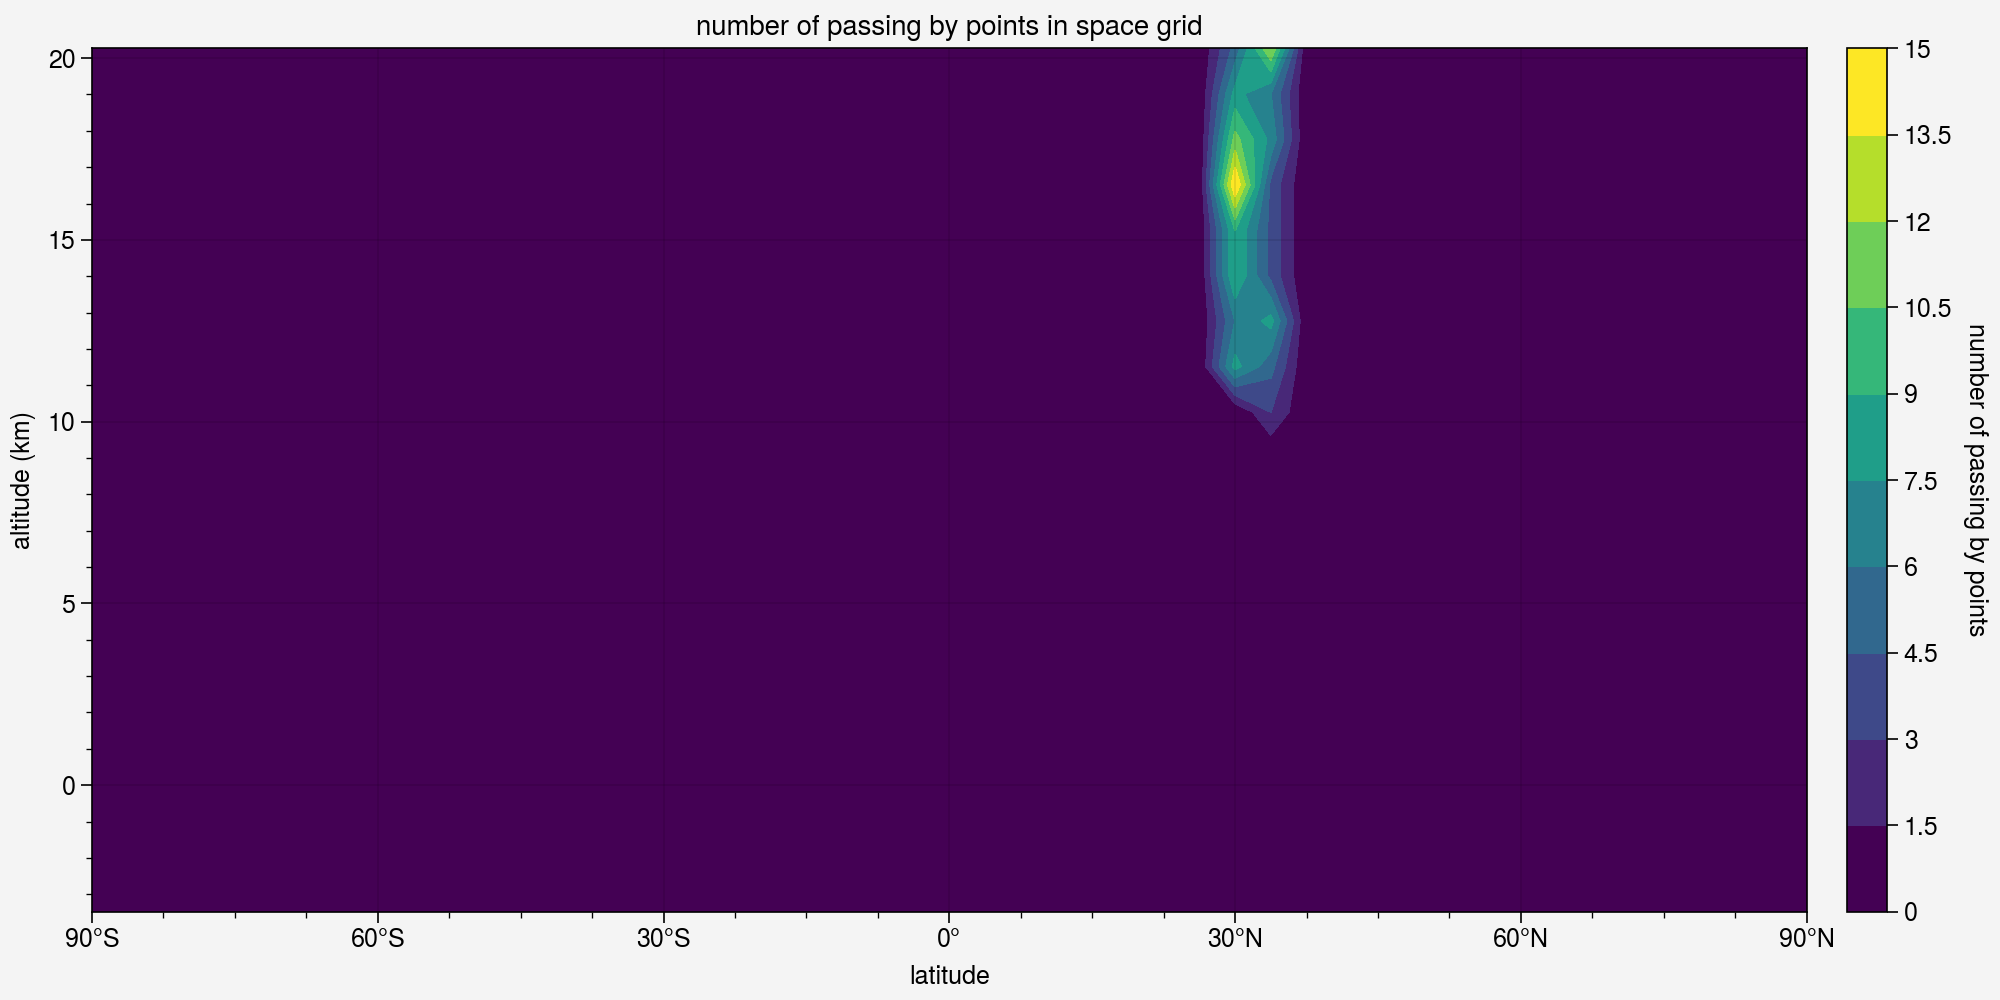

In [34]:
### just plot the passing by points in the space grid (zonal sum styleß)
tmp = np.sum(passing_by_points_count, axis=-1)
fig, ax = uplt.subplots(figsize=(10,5))
cc = ax.contourf( lat[:],alt[:-20]/1000, tmp[1,:-20,:], cmap='viridis')
ax.colorbar(cc, label='number of passing by points')
ax.format(xlabel='latitude',ylabel='altitude (km)',title='number of passing by points in space grid',
		  xformatter='deglat',xlim=(-90,90),xlocator=30)

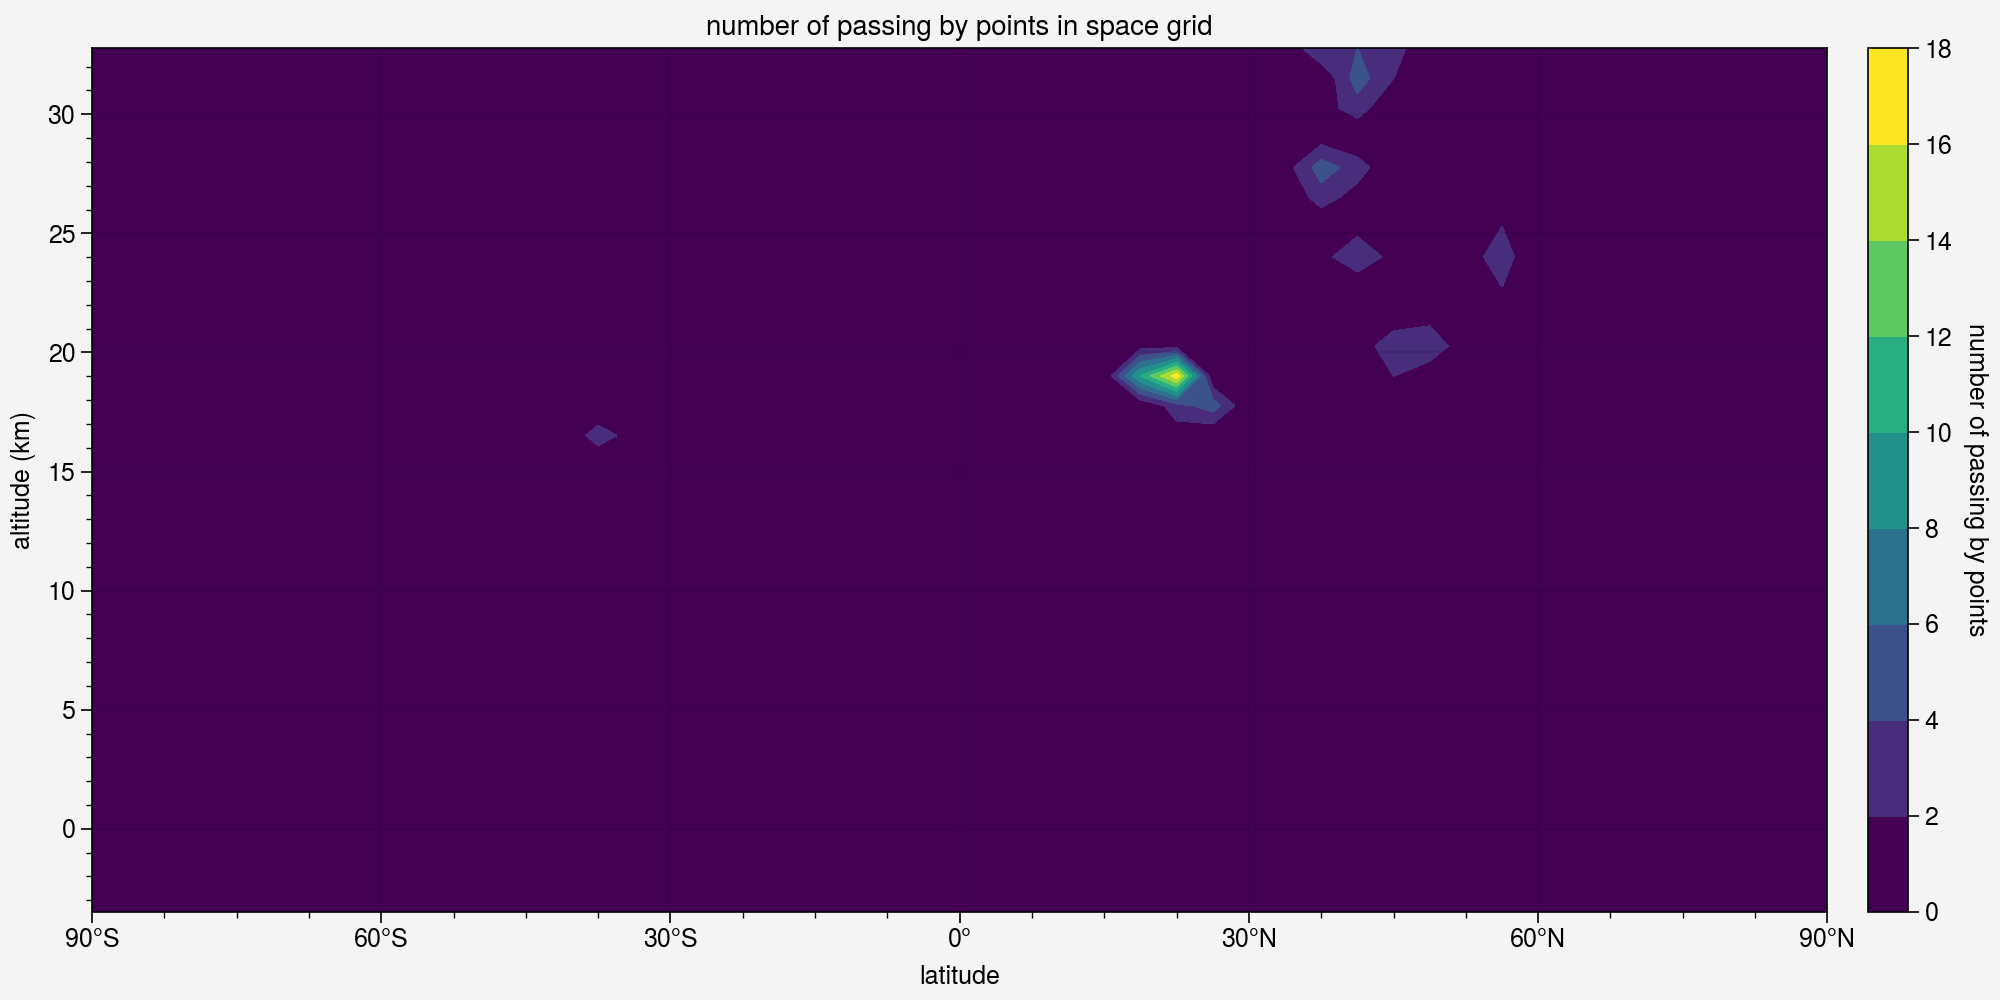

In [37]:
### just plot the passing by points in the space grid (zonal sum styleß)
tmp = np.sum(passing_by_points_count, axis=-1)
fig, ax = uplt.subplots(figsize=(10,5))
cc = ax.contourf( lat[:],alt[:-10]/1000, tmp[540,:-10,:], cmap='viridis')
ax.colorbar(cc, label='number of passing by points')
ax.format(xlabel='latitude',ylabel='altitude (km)',title='number of passing by points in space grid',
		  xformatter='deglat',xlim=(-90,90),xlocator=30)